In [4]:
import xlwings as xw
import quantstats as qs
from pathlib import Path

filename = Path("stock_report.xlsx")
wb = xw.Book(filename)
sheet = wb.sheets["Report"]
def generate_report(ticker):
    stock_data = qs.utils.download_returns(ticker)

    snapshot_path = Path('snapshot.png')
    heatmap_path = Path('return_heatmap.png')

    title = f"{ticker} Performance"

    stock_snapshot = qs.plots.snapshot(stock_data,  
                                      title=title, 
                                      savefig=snapshot_path,
                                      show=False)

    stock_heatmap = qs.plots.monthly_heatmap(stock_data, 
                                             savefig=heatmap_path,
                                             show=False)

    sheet.pictures.add(snapshot_path.absolute(), 
                     name='snapshot', 
                     update=True)

    sheet.pictures.add(heatmap_path.absolute(), 
                     name='heatmap', 
                     update=True)

    wb.to_pdf(ticker + ' Stock Report')
ticker = "COFORGE.NS"
sheet.range('C3').value = ticker
wb.save("stock_report.xlsx")
generate_report(ticker)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  1 of 1 completed
Nifty 50 Index Returns
5-Year Return: 185.10%
10-Year Return: 319.37%

Portfolio Returns
5-Year Return: 335.21%
10-Year Return: 355.38%


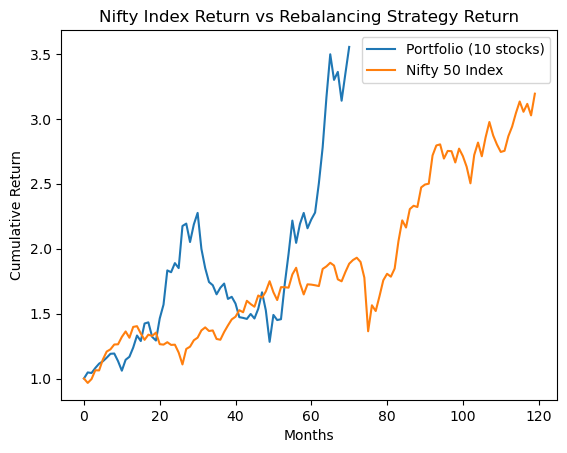

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

tickers =["COFORGE.NS","PGHH.NS","ALKEM.NS","BSOFT.NS","GUFICBIO.NS","SUNPHARMA.NS","ELNET.BO","LINCOPH.BO","ZYDUSLIFE.NS","SONATSOFTW.NS"]

stock_data = yf.download(tickers, start='2012-01-01', end='2022-01-01', interval='1mo')  # Extend the date range for a longer analysis
stock_data = stock_data.dropna()     

nifty = yf.download("^NSEI", start='2013-12-01', end='2023-12-01', interval='1mo')

stock_returns = pd.DataFrame()

for ticker in tickers:
    stock_returns[ticker] = stock_data['Adj Close'][ticker].pct_change()

stock_returns = stock_returns.dropna()

nifty["monthly_returns"] = nifty["Adj Close"].pct_change().fillna(0)

def calculate_returns(data, years):
    df = data.copy()
    months = 12 * years
    df = df.iloc[-months:]  # Select the data for the specified number of years
    df['cumulative_returns'] = (1 + df['monthly_returns']).cumprod()
    return df['cumulative_returns'].iloc[-1]

def portfolio(data, numStocks, numRev):
    df = data.copy()
    selected_stocks = []
    avg_monthly_ret = [0]
    for i in range(len(df)):
        if len(selected_stocks) > 0:
            avg_monthly_ret.append(df[selected_stocks].iloc[i,:].mean())
            bad_stocks = df[selected_stocks].iloc[i,:].sort_values(ascending=True)[:numRev].index.values.tolist()
            selected_stocks = [t for t in selected_stocks if t not in bad_stocks]
        fill = numStocks - len(selected_stocks)
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        selected_stocks = selected_stocks + new_picks
    returns_df = pd.DataFrame(np.array(avg_monthly_ret), columns=["monthly_returns"])
    return returns_df 

# Calculate returns for the specified periods
nifty_5yr_return = calculate_returns(nifty, 5)
nifty_10yr_return = calculate_returns(nifty, 10)

portfolio_5yr_return = calculate_returns(portfolio(stock_returns, 5, 2), 5)
portfolio_10yr_return = calculate_returns(portfolio(stock_returns, 5, 2), 10)

# Print returns
print("Nifty 50 Index Returns")
print("5-Year Return: {:.2%}".format(nifty_5yr_return))
print("10-Year Return: {:.2%}".format(nifty_10yr_return))

print("\nPortfolio Returns")
print("5-Year Return: {:.2%}".format(portfolio_5yr_return))
print("10-Year Return: {:.2%}".format(portfolio_10yr_return))

# Plot the cumulative returns
fig, ax = plt.subplots()
plt.plot((1 + portfolio(stock_returns, 5, 2)).cumprod(), label='Portfolio (10 stocks)')
plt.plot((1 + nifty["monthly_returns"].reset_index(drop=True)).cumprod(), label='Nifty 50 Index')
plt.title("Nifty Index Return vs Rebalancing Strategy Return")
plt.ylabel("Cumulative Return")
plt.xlabel("Months")
ax.legend()
plt.show()


In [9]:
import yfinance as yf
import pandas as pd

def get_stock_data(tickers, start_date, end_date):
    stock_data = {}
    
    for ticker in tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date)
            stock_data[ticker] = data['Adj Close']
        except Exception as e:
            print(f"Error downloading data for {ticker}: {e}")

    return pd.DataFrame(stock_data)

def calculate_portfolio_returns(portfolio, start_date, end_date):
    stock_data = get_stock_data(portfolio, start_date, end_date)

    # Calculate cumulative returns for each stock
    cumulative_returns = {}
    cumulative_returns['10Y'] = (stock_data.iloc[-1] - stock_data.iloc[0]) / stock_data.iloc[0]
    cumulative_returns['5Y'] = (stock_data.iloc[-1] - stock_data.iloc[-(5*252)]) / stock_data.iloc[-(5*252)]
    cumulative_returns['1Y'] = (stock_data.iloc[-1] - stock_data.iloc[-252]) / stock_data.iloc[-252]

    return cumulative_returns

def calculate_combined_portfolio_return(portfolio_returns):
    combined_returns = {}
    
    for timeframe, return_values in portfolio_returns.items():
        combined_returns[timeframe] = return_values.sum() / len(return_values)

    return combined_returns

# Example: Portfolio of 10 stocks
portfolio_tickers = ["COFORGE.NS","PGHH.NS","ALKEM.NS","BSOFT.NS","GUFICBIO.NS","SUNPHARMA.NS","ELNET.BO","LINCOPH.Bo","ZYDUSLIFE.NS","SONATSOFTW.NS"]
start_date = '2013-12-01'
end_date = '2023-12-01'

portfolio_returns = calculate_portfolio_returns(portfolio_tickers, start_date, end_date)

# Calculate combined portfolio returns
combined_portfolio_returns = calculate_combined_portfolio_return(portfolio_returns)

# Print results
print("\nPortfolio Cumulative Returns:")
for timeframe, return_values in portfolio_returns.items():
    for ticker, return_value in return_values.items():
        print(f"{timeframe} Cumulative Return for {ticker}: {return_value:.2%}")

# Print combined portfolio returns
print("\nCombined Portfolio Returns:")
for timeframe, return_value in combined_portfolio_returns.items():
    print(f"{timeframe} Combined Portfolio Return: {return_value:.2%}")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Portfolio Cumulative Returns:
10Y Cumulative Return for COFORGE.NS: 1995.51%
10Y Cumulative Return for PGHH.NS: 600.66%
10Y Cumulative Return for ALKEM.NS: nan%
10Y Cumulative Return for BSOFT.NS: 733.74%
10Y Cumulative Return for GUFICBIO.NS: 5922.49%
10Y Cumulative Return for SUNPHARMA.NS: 119.76%
10Y Cumu